# Wealth Dynamics

------

#### John Stachurski

#### Prepared for the CBC Workshop (May 2024)

In this lecture we examine wealth dynamics in large cross-section of agents who
are subject to both 

* idiosyncratic shocks, which affect labor income and returns, and 
* an aggregate shock, which also impacts on labor income and returns


In most macroeconomic models savings and consumption are determined by optimization.

Here savings and consumption behavior is taken as given -- you can plug in your
favorite model to obtain savings behavior and then analyze distribution dynamics
using the techniques described below.

On of our interests will be how different aspects of wealth dynamics -- such
as labor income and the rate of return on investments -- feed into measures of
inequality, such as the Gini coefficent.

Please uncomment the following if necessary

In [1]:
#!pip install quantecon 

We use the following imports.

In [2]:
import numba
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
import jax
import jax.numpy as jnp
from time import time

In [4]:
!nvidia-smi

Fri May 10 14:52:23 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080        Off |   00000000:3E:00.0 Off |                  N/A |
| 30%   29C    P8             25W /  320W |       9MiB /  10240MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

/home/john/anaconda3/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Wealth dynamics


Wealth evolves as follows:

```{math}
    w_{t+1} = (1 + r_{t+1}) s(w_t) + y_{t+1}
```

Here

- $w_t$ is wealth at time $t$ for a given household,
- $r_t$ is the rate of return of financial assets,
- $y_t$ is labor income and
- $s(w_t)$ is savings (current wealth minus current consumption)


There is an aggregate state process 

$$
    z_{t+1} = a z_t + b + \sigma_z \epsilon_{t+1}
$$

that affects the interest rate and labor income.

In particular, the gross interest rates obeys

$$
    R_t := 1 + r_t = c_r \exp(z_t) + \exp(\mu_r + \sigma_r \xi_t)
$$

while

$$
    y_t = c_y \exp(z_t) + \exp(\mu_y + \sigma_y \zeta_t)
$$

The tuple $\{ (\epsilon_t, \xi_t, \zeta_t) \}$ is IID and standard normal in $\mathbb R^3$.

(Each household receives their own idiosyncratic shocks.)

Regarding the savings function $s$, our default model will be

```{math}
:label: sav_ah

s(w) = s_0 w \cdot \mathbb 1\{w \geq \hat w\}
```

where $s_0$ is a positive constant.

Thus, 

* for $w < \hat w$, the household saves nothing, while
* for $w \geq \bar w$, the household saves a fraction $s_0$ of their wealth.



## Implementation (Numba version)


Here's a function that collects parameters and useful constants

In [5]:
def create_wealth_model(w_hat=1.0,   # Savings parameter
                        s_0=0.75,    # Savings parameter
                        c_y=1.0,     # Labor income parameter
                        μ_y=1.0,     # Labor income parameter
                        σ_y=0.2,     # Labor income parameter
                        c_r=0.05,    # Rate of return parameter
                        μ_r=0.1,     # Rate of return parameter
                        σ_r=0.5,     # Rate of return parameter
                        a=0.5,       # Aggregate shock parameter
                        b=0.0,       # Aggregate shock parameter
                        σ_z=0.1):    # Aggregate shock parameter
    """
    Create a wealth model with given parameters. 

    Return a tuple model = (household_params, aggregate_params), where
    household_params collects household information and aggregate_params
    collects information relevant to the aggregate shock process.
    
    """
    # Mean and variance of z process
    z_mean = b / (1 - a)
    z_var = σ_z**2 / (1 - a**2)
    exp_z_mean = np.exp(z_mean + z_var / 2)
    # Mean of R and y processes
    R_mean = c_r * exp_z_mean + np.exp(μ_r + σ_r**2 / 2)
    y_mean = c_y * exp_z_mean + np.exp(μ_y + σ_y**2 / 2)
    # Test stability condition ensuring wealth does not diverge
    # to infinity.
    α = R_mean * s_0
    if α >= 1:
        raise ValueError("Stability condition failed.")
    # Pack values into tuples and return them
    household_params = (w_hat, s_0, c_y, μ_y, σ_y, c_r, μ_r, σ_r, y_mean)
    aggregate_params = (a, b, σ_z, z_mean, z_var)
    model = household_params, aggregate_params
    return model

Here's a function that generates the aggregate state process

In [6]:
@numba.jit
def generate_aggregate_state_sequence(aggregate_params, length=100):
    a, b, σ_z, z_mean, z_var = aggregate_params 
    z = np.empty(length+1)
    z[0] = z_mean   # Initialize at z_mean
    for t in range(length):
        z[t+1] = a * z[t] + b + σ_z * np.random.randn()
    return z

Here's a function that updates household wealth by one period, taking the
current value of the aggregate shock.

In [7]:
@numba.jit
def update_wealth(household_params, w, z):
    """
    Generate w_{t+1} given w_t and z_{t+1}.
    """
    # Unpack
    w_hat, s_0, c_y, μ_y, σ_y, c_r, μ_r, σ_r, y_mean = household_params
    # Update wealth
    y = c_y * np.exp(z) + np.exp(μ_y + σ_y * np.random.randn())
    wp = y
    if w >= w_hat:
        R = c_r * np.exp(z) + np.exp(μ_r + σ_r * np.random.randn())
        wp += R * s_0 * w
    return wp

Here's function to simulate the time series of wealth for an individual household.

In [8]:
@numba.jit
def wealth_time_series(model, w_0, sim_length):
    """
    Generate a single time series of length sim_length for wealth given initial
    value w_0.  The function generates its own aggregate shock sequence.

    """
    # Unpack
    household_params, aggregate_params = model
    a, b, σ_z, z_mean, z_var = aggregate_params 
    # Initialize and update
    z = generate_aggregate_state_sequence(aggregate_params, 
                                          length=sim_length)
    w = np.empty(sim_length)
    w[0] = w_0
    for t in range(sim_length-1):
        w[t+1] = update_wealth(household_params, w[t], z[t+1])
    return w

Let's look at the wealth dynamics of an individual household.

In [9]:
model = create_wealth_model()
household_params, aggregate_params = model
w_hat, s_0, c_y, μ_y, σ_y, c_r, μ_r, σ_r, y_mean = household_params
a, b, σ_z, z_mean, z_var = aggregate_params 
ts_length = 200
w = wealth_time_series(model, y_mean, ts_length)

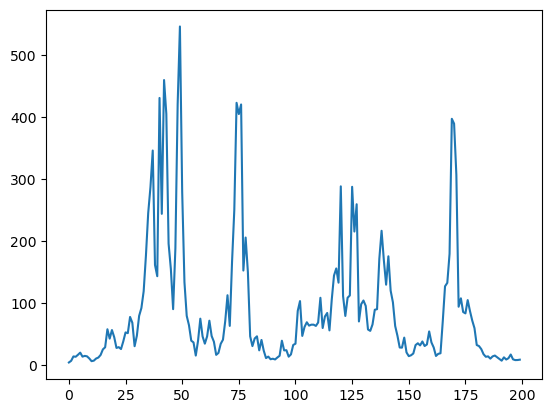

In [10]:
fig, ax = plt.subplots()
ax.plot(w)
plt.show()

Notice the large spikes in wealth over time.

Such spikes are related to heavy tails in the wealth distribution, which we
discuss below.

Here's function to simulate a cross section of households forward in time.

Note the use of parallelization to speed up computation.

In [11]:
@numba.jit(parallel=True)
def update_cross_section(model, w_distribution, z_sequence):
    """
    Shifts a cross-section of household forward in time

    Takes 

        * a current distribution of wealth values as w_distribution and
        * an aggregate shock sequence z_sequence

    and updates each w_t in w_distribution to w_{t+j}, where
    j = len(z_sequence).

    Returns the new distribution.

    """
    # Unpack
    household_params, aggregate_params = model

    num_households = len(w_distribution)
    new_distribution = np.empty_like(w_distribution)
    z = z_sequence

    # Update each household
    for i in numba.prange(num_households):
        w = w_distribution[i]
        for t in range(sim_length):
            w = update_wealth(household_params, w, z[t])
        new_distribution[i] = w
    return new_distribution

Parallelization works in the function above because the time path of each
household can be calculated independently once the path for the aggregate state
is known.

Let's see how long it takes to shift a large cross-section of households forward
200 periods

In [12]:
sim_length = 200
num_households = 10_000_000
ψ_0 = np.full(num_households, y_mean)  # Initial distribution
z_sequence = generate_aggregate_state_sequence(aggregate_params,
                                               length=sim_length)
print("Generating cross-section using Numba")
start_time = time()
ψ_star = update_cross_section(model, ψ_0, z_sequence)
numba_time = time() - start_time
print(f"Generated cross-section in {numba_time} seconds.\n")

Generating cross-section using Numba
Generated cross-section in 15.586360454559326 seconds.



## Wealth dynamics using JAX

Let's redo some of the preceding calculations using JAX and see how execution
speed compares.

### Replicating the wealth dynamics code with JAX

In [13]:
def update_cross_section_jax(model, w_distribution, z_sequence, key):
    """
    Shifts a cross-section of household forward in time

    Takes 

        * a current distribution of wealth values as w_distribution and
        * an aggregate shock sequence z_sequence

    and updates each w_t in w_distribution to w_{t+j}, where
    j = len(z_sequence).

    Returns the new distribution.

    """
    # Unpack, simplify names
    household_params, aggregate_params = model
    w_hat, s_0, c_y, μ_y, σ_y, c_r, μ_r, σ_r, y_mean = household_params
    w = w_distribution
    n = len(w)

    # Update wealth
    for t, z in enumerate(z_sequence):
        U = jax.random.normal(key, (2, n))
        y = c_y * jnp.exp(z) + jnp.exp(μ_y + σ_y * U[0, :])
        R = c_r * jnp.exp(z) + jnp.exp(μ_r + σ_r * U[1, :])
        w = y + jnp.where(w < w_hat, 0.0, R * s_0 * w) 
        key, subkey = jax.random.split(key)

    return w

Let's see how long it takes to shift the cross-section of households forward
using JAX

In [14]:
sim_length = 200
num_households = 10_000_000
ψ_0 = jnp.full(num_households, y_mean)  # Initial distribution
z_sequence = generate_aggregate_state_sequence(aggregate_params,
                                               length=sim_length)
z_sequence = jnp.array(z_sequence)

In [15]:
print("Generating cross-section using JAX")
key = jax.random.PRNGKey(1234)
start_time = time()
ψ_star = update_cross_section_jax(model, ψ_0, z_sequence, key)
jax_time = time() - start_time
print(f"Generated cross-section in {jax_time} seconds.\n")

Generating cross-section using JAX
Generated cross-section in 1.2917253971099854 seconds.



In [16]:
print("Repeating without compile time.")
key = jax.random.PRNGKey(1234)
start_time = time()
ψ_star = update_cross_section_jax(model, ψ_0, z_sequence, key)
jax_time = time() - start_time
print(f"Generated cross-section in {jax_time} seconds")

Repeating without compile time.
Generated cross-section in 0.665935754776001 seconds


And let's see how long it takes if we compile the loop.

In [17]:
def update_cross_section_jax_compiled(model, 
                                      w_distribution, 
                                      w_size,
                                      z_sequence, 
                                      key):
    """
    Shifts a cross-section of household forward in time

    Takes 

        * a current distribution of wealth values as w_distribution and
        * an aggregate shock sequence z_sequence

    and updates each w_t in w_distribution to w_{t+j}, where
    j = len(z_sequence).

    Returns the new distribution.

    """
    # Unpack, simplify names
    household_params, aggregate_params = model
    w_hat, s_0, c_y, μ_y, σ_y, c_r, μ_r, σ_r, y_mean = household_params
    w = w_distribution
    n = len(w)
    z = z_sequence
    sim_length = len(z)

    def body_function(t, state):
        key, w = state
        key, subkey = jax.random.split(key)
        U = jax.random.normal(subkey, (2, n))
        y = c_y * jnp.exp(z[t]) + jnp.exp(μ_y + σ_y * U[0, :])
        R = c_r * jnp.exp(z[t]) + jnp.exp(μ_r + σ_r * U[1, :])
        w = y + jnp.where(w < w_hat, 0.0, R * s_0 * w) 
        return key, w

    key, w = jax.lax.fori_loop(0, sim_length, body_function, (key, w))
    return w

In [18]:
update_cross_section_jax_compiled = jax.jit(
        update_cross_section_jax_compiled, static_argnums=(2,)
)

In [19]:
print("Generating cross-section using JAX with compiled loop")
key = jax.random.PRNGKey(1234)
start_time = time()
ψ_star = update_cross_section_jax_compiled(
        model, ψ_0, num_households, z_sequence, key
)
jax_fori_time = time() - start_time
print(f"Generated cross-section in {jax_fori_time} seconds.\n")

Generating cross-section using JAX with compiled loop
Generated cross-section in 0.2124497890472412 seconds.



In [20]:
print("Repeating without compile time")
key = jax.random.PRNGKey(1234)
start_time = time()
ψ_star = update_cross_section_jax_compiled(
        model, ψ_0, num_households, z_sequence, key
)
jax_fori_time = time() - start_time
print(f"Generated cross-section in {jax_fori_time} seconds")

Repeating without compile time
Generated cross-section in 0.20017671585083008 seconds


In [21]:
print(f"JAX is {numba_time / jax_fori_time:.4f} times faster.\n")

JAX is 77.8630 times faster.



### Pareto tails

In most countries, the cross-sectional distribution of wealth exhibits a Pareto
tail (power law).


Let's see if our model can replicate this stylized fact by running a simulation
that generates a cross-section of wealth and generating a suitable rank-size plot.

We will use the function `rank_size` from `quantecon` library.

In the limit, data that obeys a power law generates a straight line.

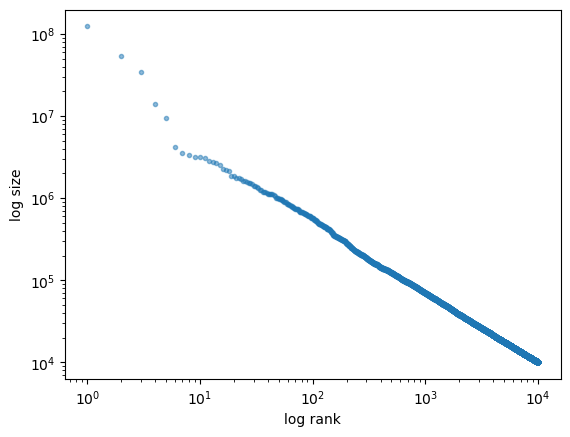

In [22]:
model = create_wealth_model()
key = jax.random.PRNGKey(1234)
ψ_star = update_cross_section_jax_compiled(
        model, ψ_0, num_households, z_sequence, key
)
fig, ax = plt.subplots()

rank_data, size_data = qe.rank_size(ψ_star, c=0.001)
ax.loglog(rank_data, size_data, 'o', markersize=3.0, alpha=0.5)
ax.set_xlabel("log rank")
ax.set_ylabel("log size")

plt.show()

### Lorenz curves and Gini coefficents

To study the impact of parameters on inequality, we examine Lorenz curves
and the Gini coefficients at different parameters.

QuantEcon provides functions to compute Lorenz curves and gini coefficients that are accelerated using Numba.

Here we provide JAX-based functions that do the same job and are faster for large data sets on parallel hardware.


#### Lorenz curve

Recall that, for sorted data $w_1, \ldots, w_n$, the Lorenz curve 
generates data points $(x_i, y_i)_{i=0}^n$  according to

\begin{equation*}
    x_0 = y_0 = 0
    \qquad \text{and, for $i \geq 1$,} \quad
    x_i = \frac{i}{n},
    \qquad
    y_i =
       \frac{\sum_{j \leq i} w_j}{\sum_{j \leq n} w_j}  
\end{equation*}

In [23]:
def _lorenz_curve_jax(w, w_size):
    n = w.shape[0]
    w = jnp.sort(w)
    x = jnp.arange(n + 1) / n
    s = jnp.concatenate((jnp.zeros(1), jnp.cumsum(w)))
    y = s / s[n]
    return x, y

lorenz_curve_jax = jax.jit(_lorenz_curve_jax, static_argnums=(1,))

Let's test

In [24]:
sim_length = 200
num_households = 1_000_000
ψ_0 = jnp.full(num_households, y_mean)  # Initial distribution
z_sequence = generate_aggregate_state_sequence(aggregate_params,
                                               length=sim_length)
z_sequence = jnp.array(z_sequence)

In [25]:
key = jax.random.PRNGKey(1234)
ψ_star = update_cross_section_jax_compiled(
        model, ψ_0, num_households, z_sequence, key
)

In [26]:
%time _ = lorenz_curve_jax(ψ_star, num_households)

CPU times: user 675 ms, sys: 8 ms, total: 683 ms
Wall time: 1 s


In [27]:
%time x, y = lorenz_curve_jax(ψ_star, num_households)

CPU times: user 608 µs, sys: 0 ns, total: 608 µs
Wall time: 453 µs


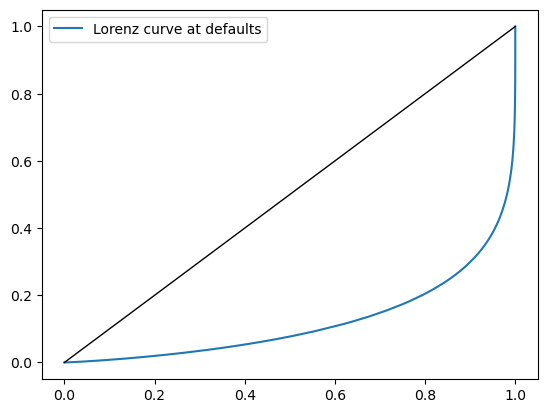

In [28]:
fig, ax = plt.subplots()
ax.plot(x, y, label="Lorenz curve at defaults")
ax.plot(x, x, 'k-', lw=1)
ax.legend()
plt.show()

#### Gini Coefficient

Recall that, for sorted data $w_1, \ldots, w_n$, the Gini coefficient takes the form

\begin{equation}
    \label{eq:gini}
    G :=
    \frac
        {\sum_{i=1}^n \sum_{j = 1}^n |w_j - w_i|}
        {2n\sum_{i=1}^n w_i}.
\end{equation}


Here's a function that computes the Gini coefficient using vectorization.

In [29]:
def _gini_jax(w, w_size):
    w_1 = jnp.reshape(w, (w_size, 1))
    w_2 = jnp.reshape(w, (1, w_size))
    g_sum = jnp.sum(jnp.abs(w_1 - w_2))
    return g_sum / (2 * w_size * jnp.sum(w))

gini_jax = jax.jit(_gini_jax, static_argnums=(1,))

In [30]:
%time gini = gini_jax(ψ_star, num_households).block_until_ready()

CPU times: user 59 ms, sys: 12 µs, total: 59 ms
Wall time: 3.69 s


In [31]:
%time gini = gini_jax(ψ_star, num_households).block_until_ready()
gini

CPU times: user 1.55 ms, sys: 3.99 ms, total: 5.54 ms
Wall time: 3.59 s


Array(0.7584409, dtype=float32)

**Exercise**

See if you can write an alternative version of `gini_jax` that uses `vmap` instead of reshaping and broadcasting.

Test with the same array to see if you can obtain the same output.

In [32]:
for i in range(12):
    print("Solution below.")

Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.


**Solution**

Here's one solution:

In [33]:
@jax.jit
def gini_jax_vmap(w):

    def _inner_sum(x):
        return jnp.sum(jnp.abs(x - w))
    
    inner_sum = jax.vmap(_inner_sum)
    
    full_sum = jnp.sum(inner_sum(w))
    return full_sum / (2 * len(w) * jnp.sum(w))

In [34]:
%time gini = gini_jax_vmap(ψ_star).block_until_ready()
gini

CPU times: user 46.9 ms, sys: 32 ms, total: 78.9 ms
Wall time: 3.71 s


Array(0.7584409, dtype=float32)

In [35]:
%time gini = gini_jax_vmap(ψ_star).block_until_ready()
gini

CPU times: user 5.11 ms, sys: 21 µs, total: 5.13 ms
Wall time: 3.61 s


Array(0.7584409, dtype=float32)

### Inequality and dynamics

In this section we (you) investigate how the parameters determining the rate of return on assets and labor income shape inequality.

In doing so we recall that

$$
    R_t := 1 + r_t = c_r \exp(z_t) + \exp(\mu_r + \sigma_r \xi_t)
$$

while

$$
    y_t = c_y \exp(z_t) + \exp(\mu_y + \sigma_y \zeta_t)
$$

**Exercise**

Investigate how the Lorenz curves and the Gini coefficient associated with the wealth distribution change as return to savings varies.

In particular, plot Lorenz curves for the following three different values of $\mu_r$.

In [36]:
μ_r_vals = (0.0, 0.025, 0.05)

Youse the following as your initial cross-sectional distribution

In [37]:
num_households = 1_000_000
ψ_0 = jnp.full(num_households, y_mean)  # Initial distribution

Once you have done that, plot the Gini coefficients as well.

Do the outcomes match your intuition?

In [38]:
for i in range(12):
    print("Solution below.")

Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.
Solution below.


**Solution**

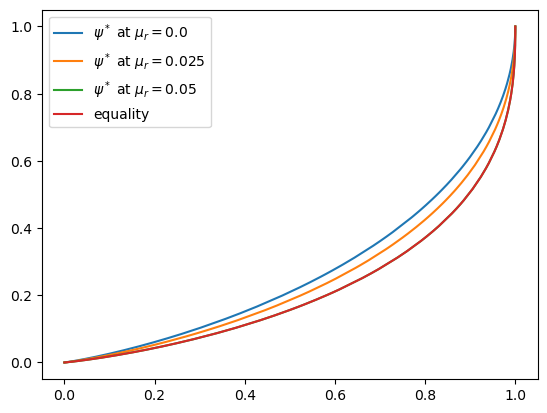

In [39]:
key = jax.random.PRNGKey(1234)
fig, ax = plt.subplots()
gini_vals = []
for μ_r in μ_r_vals:
    model = create_wealth_model(μ_r=μ_r)
    ψ_star = update_cross_section_jax_compiled(
            model, ψ_0, num_households, z_sequence, key
    )
    x, y = lorenz_curve_jax(ψ_star, num_households)
    g = gini_jax(ψ_star, num_households)
    ax.plot(x, y, label=f'$\psi^*$ at $\mu_r = {μ_r:0.2}$')
    gini_vals.append(g)
ax.plot(x, y, label='equality')
ax.legend(loc="upper left")
plt.show()

The Lorenz curve shifts downwards as returns on financial income rise, indicating a rise in inequality.

Now let's check the Gini coefficient.

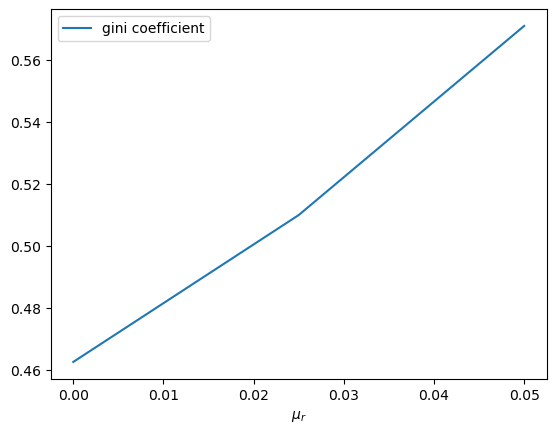

In [40]:
fig, ax = plt.subplots()
ax.plot(μ_r_vals, gini_vals, label='gini coefficient')
ax.set_xlabel("$\mu_r$")
ax.legend()
plt.show()

As expected, inequality increases as returns on financial income rise.

**Exercise**

Now investigate what happens when we change the volatility term $\sigma_r$ in financial returns.

Use the same initial condition as before and the sequence

In [41]:
σ_r_vals = (0.35, 0.45, 0.52)

To isolate the role of volatility, set $\mu_r = - \sigma_r^2 / 2$ at each $\sigma_r$.

(This holds the variance of the ideosyncratic term $\exp(\mu_r + \sigma_r \zeta)$ constant.)

In [42]:
for i in range(12):
    print("Solution below")

Solution below
Solution below
Solution below
Solution below
Solution below
Solution below
Solution below
Solution below
Solution below
Solution below
Solution below
Solution below


Here's one solution.

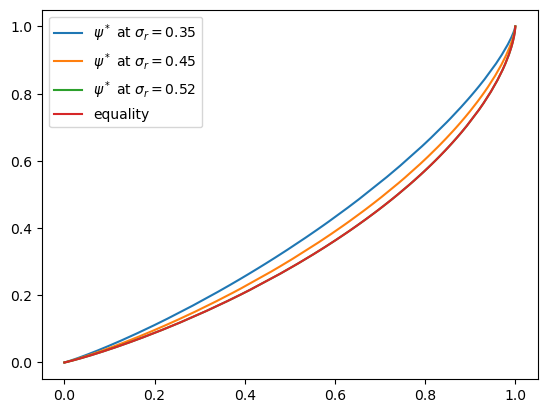

In [43]:
key = jax.random.PRNGKey(1234)
fig, ax = plt.subplots()

gini_vals = []
for σ_r in σ_r_vals:
    model = create_wealth_model(σ_r=σ_r, μ_r=(-σ_r**2/2))
    ψ_star = update_cross_section_jax_compiled(
            model, ψ_0, num_households, z_sequence, key
    )
    x, y = lorenz_curve_jax(ψ_star, num_households)
    g = gini_jax(ψ_star, num_households)
    ax.plot(x, y, label=f'$\psi^*$ at $\sigma_r = {σ_r:0.2}$')
    gini_vals.append(g)
ax.plot(x, y, label='equality')
ax.legend(loc="upper left")
plt.show()

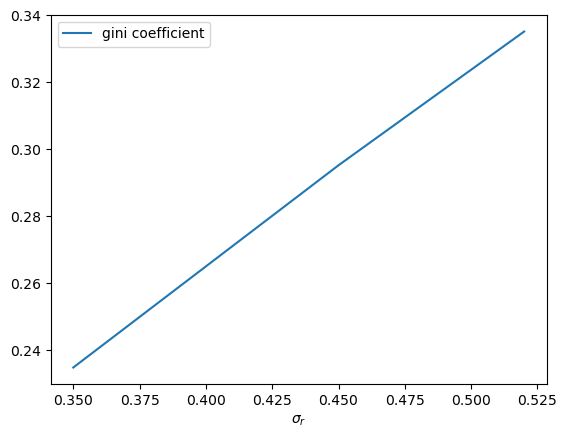

In [44]:
fig, ax = plt.subplots()
ax.plot(σ_r_vals, gini_vals, label='gini coefficient')
ax.set_xlabel("$\sigma_r$")
ax.legend()
plt.show()

**Exercise**

Which will have more impact on inequality -- a 5% rise in volatility of the rate of return, or a 5% rise in volatility of labor income?

Test this by 

1. Shifting $\sigma_r$ up 5% from the baseline and plotting the Lorenz curve
1. Shifting $\sigma_y$ up 5% from the baseline and plotting the Lorenz curve

Plot both on the same figure and examine the result.

In [45]:
for i in range(18):
    print("Solution below")

Solution below
Solution below
Solution below
Solution below
Solution below
Solution below
Solution below
Solution below
Solution below
Solution below
Solution below
Solution below
Solution below
Solution below
Solution below
Solution below
Solution below
Solution below


**Solution**

Here's one solution.

It shows that increasing volatility in financial income has the greater effect.

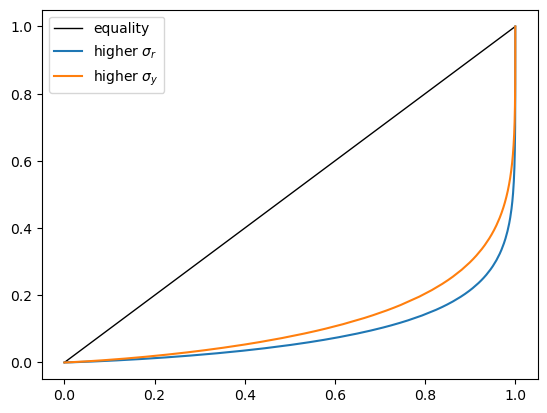

In [46]:
model = create_wealth_model()
household_params, aggregate_params = model
w_hat, s_0, c_y, μ_y, σ_y, c_r, μ_r, σ_r, y_mean = household_params
σ_r_default = σ_r
σ_y_default = σ_y

ψ_star = update_cross_section_jax_compiled(
            model, ψ_0, num_households, z_sequence, key
)
x_default, y_default = lorenz_curve_jax(ψ_star, num_households)

model = create_wealth_model(σ_r=(1.05 * σ_r_default))
ψ_star = update_cross_section_jax_compiled(
            model, ψ_0, num_households, z_sequence, key
)
x_financial, y_financial = lorenz_curve_jax(ψ_star, num_households)


model = create_wealth_model(σ_y=(1.05 * σ_y_default))
ψ_star = update_cross_section_jax_compiled(
            model, ψ_0, num_households, z_sequence, key
)
x_labor, y_labor = lorenz_curve_jax(ψ_star, num_households)

fig, ax = plt.subplots()    
ax.plot(x_default, x_default, 'k-', lw=1, label='equality')
ax.plot(x_financial, y_financial, label=r'higher $\sigma_r$')
ax.plot(x_labor, y_labor, label=r'higher $\sigma_y$')
ax.legend()
plt.show()